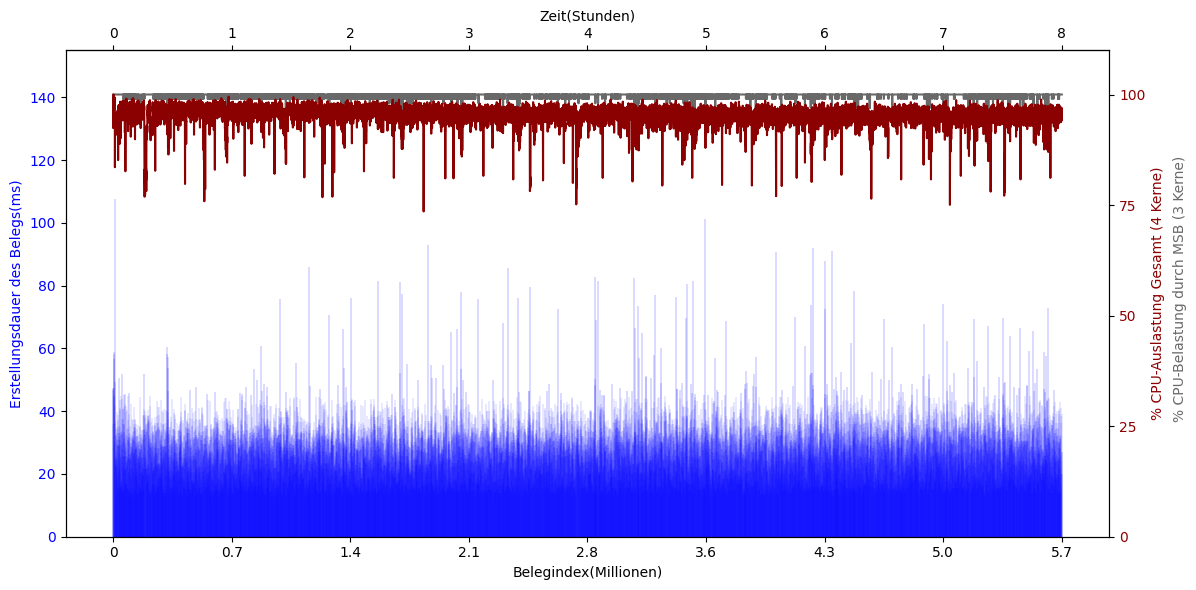

MSB top 5 values:
7072, 2024-12-17 00:00:53.483724, 107.742 ms
3546858, 2024-12-17 04:59:38.144978, 101.365 ms
1897362, 2024-12-17 02:39:26.988987, 93.104 ms
4184302, 2024-12-17 05:54:07.979819, 91.892 ms
4297206, 2024-12-17 06:03:39.044689, 90.992 ms
Standard Deviation: 8.46 ms
----------------------------------
CPU bottom 5:
                     time  total
5234  2024-12-17 01:27:23     94
17365 2024-12-17 04:49:38     95
17366 2024-12-17 04:49:39     95
4491  2024-12-17 01:15:00     96
4492  2024-12-17 01:15:01     96
Standard Deviation (Gray - only MSB - total): 0.50 %
Standard Deviation (Red - Total - msbx3): 2.17 %


In [6]:
from scipy.stats import median_abs_deviation
import find_time_indexes
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#-----------------------------------------------------------------------------------------
column = "total"
column2 = "msbx3"
left_ax_height = 155
right_ax_buffer = 0
right_ax_max = 110
group_size = 500
file1 = r'D:\BA\Results\rest\cpu.csv'
file2 = r'D:\BA\Results\rest\msb2.csv'
file_chart = r'D:\BA\Results\rest\chart.png'
start_timestamp = '2024-12-17 00:00:00'
#-----------------------------------------------------------------------------------------
tick_times = []
for i in range(7):
    result = (datetime.strptime(start_timestamp, '%Y-%m-%d %H:%M:%S') + timedelta(hours=i+1)).strftime('%Y-%m-%d %H:%M:%S')
    tick_times.append(result)

x_axe_ticks = find_time_indexes.find(file2, tick_times)
df1 = pd.read_csv(file1, low_memory=False, encoding='utf-8')
df1['time'] = pd.to_datetime(df1['time'])
df1[column] = pd.to_numeric(df1[column], errors='coerce')  # Ensure 'value' is numeric

# Process df2 in chunks
chunksize = 1_000_000  # Adjust chunk size based on your memory capacity
time_diffs = []
times = []
msb_top5 = []

for chunk in pd.read_csv(file2, usecols=['time'], chunksize=chunksize, low_memory=False):
    chunk['time'] = pd.to_datetime(chunk['time'])
    chunk['time_diff'] = chunk['time'].diff().dt.total_seconds() * 1000
    times.append(chunk['time'].iloc[1:].values)  # Skip first row since diff is NaN
    time_diffs.append(chunk['time_diff'].iloc[1:].values)  # Skip NaN diff
    chunk_data = list(zip(chunk['time_diff'].iloc[1:], chunk.index[1:], chunk['time'].iloc[1:]))
    msb_top5 = heapq.nlargest(5, heapq.merge(msb_top5, chunk_data), key=lambda x: x[0])
    
# Combine results from all chunks
df2 = pd.DataFrame({
    'time': pd.concat([pd.Series(t) for t in times], ignore_index=True),
    'time_diff': pd.concat([pd.Series(td) for td in time_diffs], ignore_index=True)
})

# Group df2 for plotting
df2['group'] = df2.index // group_size
df2 = df2.groupby('group').agg({'time': 'first', 'time_diff': 'max'}).reset_index(drop=True)

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Belegindex(Millionen)')

ax1.set_ylabel('Erstellungsdauer des Belegs(ms)', color='blue')



#ax1.vlines(df2['time'], 0, df2['time_diff'], color="blue", label='Time Diff', linewidth=0.3)    

for idx, row in df2.iterrows():
    line_width = 0.2 if row['time_diff'] > 45 else 0.13
    ax1.vlines(row['time'], 0, row['time_diff'], color="blue", linewidth=line_width)




ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, left_ax_height)

ax2 = ax1.twinx()

ax2.set_ylabel('% CPU-Auslastung Gesamt (4 Kerne)', color='darkred')
ax2.plot(df1['time'], df1[column], color='#696969', label='Red Value')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(-right_ax_buffer, +right_ax_max)  
y_ticks = range(0, 101, 25)  
ax2.set_yticks(y_ticks)

#cpu 2
ax2.plot(df1['time'], df1[column2], color='darkred')
ax2.text(1.061, 0.51, '% CPU-Belastung durch MSB (3 Kerne)', color='#696969', fontsize=10, rotation=90, transform=ax2.transAxes, va='center', ha='left')


num_rows = sum(1 for _ in open(file2, 'r', encoding='utf-8')) -1
tick_position = [df2['time'].iloc[0]]
tick_labels = ["0"]
for i in range(7):
    tick_position.append(df2['time'].iloc[int(x_axe_ticks[i]/group_size)])    
    tick_labels.append(round(x_axe_ticks[i]/1000000, 1))
tick_position.append(df2['time'].iloc[-1])
tick_labels.append(round(num_rows/1000000, 1))

ax2.set_xticks(tick_position) 
ax2.set_xticklabels(tick_labels) 
#ax2.set_xticks([tick_position])  

#if needed to make different tick_position for upper ax
#tick_position = df2['time'].iloc[x_axe_ticks/group_size]
top_ax = ax2.secondary_xaxis('top')
top_ax.set_xticks(tick_position)  
top_ax.set_xticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"], color='black')  
top_ax.set_xlabel("Zeit(Stunden)", color='black') 
top_ax.tick_params(axis='x', colors='black')

#plt.title('Comparison of Time Differences and Values Over Time')
fig.tight_layout()
plt.savefig(file_chart, dpi=300)
plt.show()

# Extract top 5 values
print("MSB top 5 values:")
for time_diff, index, timestamp in msb_top5:
    print(f"{index}, {timestamp}, {time_diff} ms")

msb_time_diffs = df2['time_diff'].dropna()  # Ensure no NaN values
msb_std = msb_time_diffs.std()  # Calculate standard deviation
print(f"Standard Deviation: {msb_std:.2f} ms")
print("----------------------------------")
cpu_bottom5 = df1.nsmallest(5, column)[['time', column]]
print("CPU bottom 5:") 
print(cpu_bottom5)

cpu_std_gray = df1[column].dropna().std()  # Standard deviation for gray 
cpu_std_red = df1[column2].dropna().std()  # Standard deviation for red 
print(f"Standard Deviation (Gray - only MSB - {column}): {cpu_std_gray:.2f} %")
print(f"Standard Deviation (Red - Total - {column2}): {cpu_std_red:.2f} %")